In [1]:
import numpy as np
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
from scipy.stats import pearsonr, chi2, kstest
import scipy.ndimage as ndimage
from astropy.io import fits

In [40]:
class MyData:
    def __init__(self):
        self.x = 0
        self.nx = 0
        self.y = 0
        self.ny = 0
        self.z = 0
        self.nz = 0
        self.filename = 'NoFile'
        self.nc=0
        self.array=0
        
    def GetData(self, fileName):
        self.filename = fileName
        data = np.loadtxt(fileName)
        try:
            self.x,self.y,self.z=data.transpose()
            #print "3 columns"
            self.nc=3
        except ValueError:
            try:
                self.x,self.y=data.transpose()
                #print "2 columns"
                self.nc=2
            except ValueError:
                self.x = data.transpose()
                #print "1 columns"
                self.nc=1
                
    def GetFits(self, filename):
        self.filename=filename
        self.array=fits.getdata(filename)   
        self.nxa=len(self.array)
        self.nya=len(self.array)
        self.header=fits.getheader(filename)
        self.ndim=2
        
    def ShowImage(self,Cliptop=0,cmap='gray'):
        plt.imshow(self.array,vmin=np.percentile(self.array,Cliptop*100),vmax=(np.percentile(self.array,100-Cliptop*100)),cmap=cmap)        
                
    def PlotPointsXY(self):
        plt.scatter(self.x, self.y)
        
    def SimData(self, model):
        self.x = model.x
        self.y = model.z
        self.z = np.random.poisson(self.y)
    
                
    def PlotPoints(self):
        plt.plot(self.x *1e9, self.y)
        plt.plot(self.x *1e9, self.z)
        plt.xlabel('wavelength(nm)')
        plt.ylabel('photons in 1e-5 sec')
        
    def LoadPoints(self):
        arr = np.zeros([128,128])
        for i in range(len(self.x)):
            arr[self.x[i], self.y[i]] = arr[self.x[i], self.y[i]]+1.0
        self.array = arr
        
class Model:
    
    def _init_(self):
        self.npt = 0
        self.x = 0
        self.y = 0
        self.type = 'undefined'
        self.sigma = []
        self.array = [0]
        
    def Xarray(self, npt, xmin = 0, xmax = 1):
        self.npt = npt
        self.x = np.linspace(xmin, xmax, npt)
        
    def Gaussian(self, xbar = 0, sigma = 1, ytotal=1):
        self.type = "Gaussian"
        self.xbar = xbar
        self.sigma = sigma
        self.ytotal = ytotal
        self.y = self.ytotal * np.exp(-(self.x - xbar)**2 / (2*sigma**2))/ (sigma *np.sqrt(2*ma.pi))
        
#    def Blackbody(self, temp=5000):
    def Blackbody(self, temp=5000, I=1):
        self.type = "Blackbody"
        self.temp = temp
        h = 6.626e-34 #m^2*kg/s
        c = 2.99792e8 #m/s
        k = 1.38e-23 #m^2*kg/s^2*K
        x = self.x * 10**-9
        a = 2.0*h*c**2
        b = h*c/(x*k*temp)
        intensity = ((a/(x**5))*(1/(np.exp(b)-1.0)))*I
        self.y = intensity
        self.sigma=np.sqrt(self.y)
    def printBlackbody(self):
        #plt.plot(self.x*1e9, self.y)
        plt.plot(self.x, self.y)
        plt.title('Blackbody')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Intensity')
        plt.show()
    def Planck(self, temp=5000):
        self.type = "Blackbody"
        self.temp = temp
        h = 6.626e-34 #m^2*kg/s
        c =  2.99792e8 #m/s
        k = 1.38e-23 #m^2*kg/s^2*K
        a = 2.0*h*c**2
        b = h*c/(self.x*k*temp)
        intensity = a/((self.x**5) * (np.exp(b) - 1.0 ))
        self.y = intensity
        
    def Best(self, Tl, Tu, Il, Iu):
        T = np.linspace(Tl, Tu, 101)
        I = np.linspace(Il, Iu, 101)
        S = np.ones([101,101])*1e10
        Smin = 1e10
        i1 = 0
        j1 = 0
        for i in range(101):
            for j in range(101):
                self.Blackbody(T[j], I[i])
                st = MyStats(D,m)
                S[i,j] = st.Sstat()
                if S[i,j]<Smin:
                    Smin = S[i,j]
                    i1 = i
                    j1 = j
        return T[i1], I[j1], Smin, T, I, S
    
    def BestTI(self, tl, tu, il, iu):
        Tbest,Ibest,Sbest, T, I, S = m.Best(tl, tu, il, iu)
        print 'T =', Tbest,'I =', Ibest,'S =',Sbest
        cont1 = chi2.isf(.999, 8)
        cont2 = chi2.isf(.95, 8)
        cont3 = chi2.isf(.68, 8)
        print ' 68%, 95% and 99.9% confidence levels are' ,Sbest+cont3,Sbest+cont2,Sbest+cont1
        cont = np.array([Sbest+cont1, Sbest+cont2, Sbest+cont3])
        fig, ax = plt.subplots()
        plt.imshow(S, extent=[tl,tu,il,iu], aspect='auto')
        plt.colorbar()
        CS = ax.contour(T, I, S, cont, colors=['r', 'y', 'w'])
        ax.clabel(CS)
        plt.xlabel('T')
        plt.ylabel('I')
        plt.show()
        return Tbest,Ibest,Sbest, T, I, S
    
    def blackbody_e(self, star, instrument, time):
        self.x = np.array(instrument.lam) * 1e-9
        self.Planck(star.temp)
        self.y = self.y * (self.x[1]-self.x[0])
        return np.sum(self.y) * 4*np.pi**2 * star.rad**2 * ( (1/(star.dist*9.46e15))**2/(4 * np.pi)) * time 

    def blackbody_ph(self, star, instrument, time):
        self.x = np.array(instrument.lam) * 1e-9
        self.Planck(star.temp)
        self.y = self.y * (self.x[1]-self.x[0])
        self.z = self.y
        h = 6.626e-34 #m^2*kg/s
        c =  2.99792e8 #m/s
        for i in range(len(self.z)):
        #self.z is the list of number of photons
            self.z[i] = self.y[i]/(h*c/self.x[i]) * 4*np.pi**2 * star.rad**2 * ( (1/(star.dist*9.46e15))**2/(4 * np.pi)) * time
        #return np.sum(self.z) * 4*np.pi**2 * star.rad**2 * ( (1/(star.dist*9.46e15))**2/(4 * np.pi)) * time
        return np.sum(self.z)
    def Linear(self,A,B):
        self.type = "Linear"
        self.y=A+B*self.x
        self.sigma=np.sqrt(self.y)
        
class MyStats: 
    
    def __init__(self, data):
        self.data = data
        #self.model = model
        self.LinearReg = []
        
    def info(self):
        if self.data.nc>=1:
            print "X: the number of data points is", len(self.data.x), ",mean is", np.mean(self.data.x), ",median is", np.median(self.data.x), ",and the standard deviation is", np.std(self.data.x) 
        if self.data.nc>=2:
            print "Y: the number of data points is", len(self.data.y), ",mean is", np.mean(self.data.y), ",median is", np.median(self.data.y), ",and the standard deviation is", np.std(self.data.y)
        if self.data.nc>=3:
            print "Z: the number of data points is", len(self.data.z), ",mean is", np.mean(self.data.z), ",median is", np.median(self.data.z), ",and the standard deviation is", np.std(self.data.z)
    
    def LinearRegression(self):
        def LR(a,b):
            N = len(a)
            sum_a = np.sum(a)
            sum_a2= np.sum(a*a)
            sum_b = np.sum(b)
            sum_b2= np.sum(b*b)
            sum_ab= np.sum(a*b)
            sigma_a2 = 0
            sigma_b2 = 0
            sigma_ab = 0

            for i in range(N):
#                sum_a2 = sum_a2+a[i]**2
#                sum_b2 = sum_b2+b[i]**2
#                sum_ab = sum_ab+a[i]*b[i]            
                sigma_a2 = sigma_a2+(np.mean(a)-a[i])**2
                sigma_b2 = sigma_b2+(np.mean(b)-b[i])**2
                sigma_ab = sigma_ab+(np.mean(a)-a[i])*(np.mean(b)-b[i])
            
            d = N*sum_a2-sum_a**2
            A = (sum_a2*sum_b-sum_a*sum_ab)/d
            B = (N*sum_ab-sum_a*sum_b)/d
            r = sigma_ab/(sigma_a2**0.5*sigma_b2**0.5)
            plt.plot(a,B*a+A,c='r')
            plt.scatter(a,b,c='g')
            
            p = pearsonr(a, b)
            
            self.LR = [A,B,r,N,p[1]]
            return [A,B,r,N,p[1]]
        x = self.data.x
        y = self.data.y
        z = self.data.z
        if self.data.nc==2:
            self.lr = LR(x,y)
            return LR(x,y)
        elif self.data.nc==3:
            self.lr = np.array([LR(x,y),LR(x,z),LR(y,z)])
            return LR(x,y),LR(x,z),LR(y,z)   
        
    def Sstat(self):
        chi = (self.model.y - self.data.y)/(self.model.sigma)
        chisq = chi**2
        S = np.sum(chisq)
        return S
    def Svalue(self, S, var):
        p = chi2.cdf(S, var)
        return p
    
    #def Cstat(self, mu, arr=self.array):
        

class Source:
    def __init__(self, name, typ, temp, rad, dist):
        self.name = name
        self.typ = typ
        self.temp = temp
        self.rad = rad
        self.dist = dist

    def info(self):
        print "The type of",self.name,'is',self.typ,'. The temperature of',self.name,'is',self.temp,'K. The radius of',self.name,'is',self.rad,'m. The distance of',self.name,'is',self.dist,'ly.'

class Sources:
    def __init__(self):
        self.Sourcelist = []
        self.source_dict = {}
        self.load_sources()
        self.load_dictionary()
    
    def load_sources(self):
        self.Sourcelist=[Source('Proxima Centauri','M6Ve',3042,107300000 ,4.244),Source('Alpha Centauri A','G2V', 5790, 851119000, 4.73),Source('Epsilon Eridani', 'K2V', 5084, 512000000, 10.48),Source('Tau Ceit', 'G8V', 5344, 552000000, 11.91)]
    
    def load_dictionary(self):
        for each in self.Sourcelist:
            self.source_dict[each.name] = each
    
    def add_sources(self,A):
        self.Sourcelist.append(A)
        self.source_dict[A.name] = A
        
class Instrument:
    def __init__(self,name='Unnamed', nlam = 100, lam_min = 100., lam_max = 1000., area = 1.):
        self.name = name
        self.nlam = nlam
        self.lam_min = lam_min
        self.lam_max = lam_max
        self.lam = np.linspace(lam_min, lam_max, nlam )
        self.areatemp = area
        self.area = self.lam * 0. + area 
        
    def info(self):
        print self.name, ': nlam =', self.nlam , ', lam_min =', self.lam_min , ', lam_max =', self.lam_max , ', area =', self.area[0]

class Instruments:
    def __init__(self):
        self.instrumentlist = []
        self.instrument_dict = {}
        self.load_instruments()
        self.load_dictionary()
    
    def load_instruments(self):    
        self.instrumentlist=[Instrument(name='Generic', nlam = 100, lam_min = 100.,lam_max = 2000., area = 1.)]
    
    def load_dictionary(self):
        for each in self.instrumentlist:
            self.instrument_dict[each.name] = each
            
    def add_instruments(self,A):
        self.instrumentlist.append(A)
        self.instrument_dict[A.name] = A

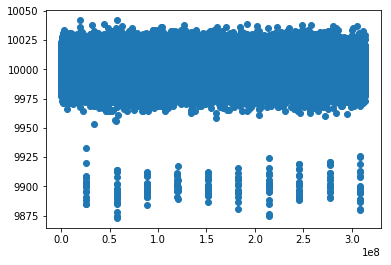

In [3]:
D = MyData()
D.GetData('final_c.txt')
D.PlotPointsXY() # Obviously, there are at least one planet in this system

In [18]:
x1 = D.x[:9999]
y1 = D.y[:9999]

x2 = D.x[10000:19999]
y2 = D.y[10000:19999]
 
x3 = D.x[20000:29999]
y3 = D.y[20000:29999]

x4 = D.x[30000:39999]
y4 = D.y[30000:39999]

x5 = D.x[40000:49999]
y5 = D.y[40000:49999]

x6 = D.x[50000:59999]
y6 = D.y[50000:59999]

x7 = D.x[60000:69999]
y7 = D.y[60000:69999]

x8 = D.x[70000:79999]
y8 = D.y[70000:79999]

x9 = D.x[80000:89999]
y9 = D.y[80000:89999]

x10 = D.x[90000:99999]
y10 = D.y[90000:99999]

print np.where(np.min(y1)==y1)
print np.where(np.min(y2)==y2)
print np.where(np.min(y3)==y3)
print np.where(np.min(y4)==y4)
print np.where(np.min(y5)==y5)
print np.where(np.min(y6)==y6)
print np.where(np.min(y7)==y7)
print np.where(np.min(y8)==y8)
print np.where(np.min(y9)==y9)
print np.where(np.min(y10)==y10)

(array([8250, 8263]),)
(array([8259]),)
(array([8264]),)
(array([8266]),)
(array([8255]),)
(array([8253]),)
(array([8258]),)
(array([8265]),)
(array([8254]),)
(array([8266]),)


In [20]:
Max = [(8250+8263)/2, 8259, 8264, 8266, 8255, 8253, 8258, 8265, 8254, 8266]

8258 0 0.12021416366


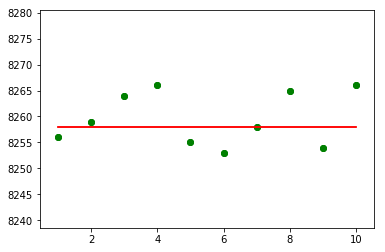

In [44]:
d = MyData()
d.x = np.array([1,2,3,4,5,6,7,8,9,10])
d.y = np.array(Max)
d.nc = 2
Stats = MyStats(d)
#Stats.info()
lr=Stats.LinearRegression()
print lr[0], lr[1], lr[2] # the linearrelationship shows that the peorid is 10000*3140s, when t = n*10000*3140s + 8258, the planet transit. 

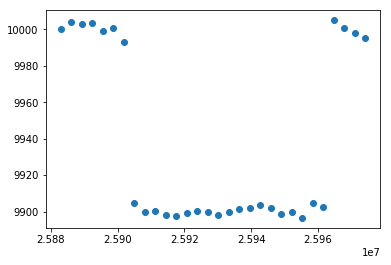

In [56]:
x11 = D.x[8258-15 : 8258+15]
y11 = D.y[8258-15 : 8258+15]

x21 = D.x[18258-15 : 18258+15]
y21 = D.y[18258-15 : 18258+15]

x31 = D.x[28258-15 : 28258+15]
y31 = D.y[28258-15 : 28258+15]

x41 = D.x[38258-15 : 38258+15]
y41 = D.y[38258-15 : 38258+15]

x51 = D.x[48258-15 : 48258+15]
y51 = D.y[48258-15 : 48258+15]

x61 = D.x[58258-15 : 58258+15]
y61 = D.y[58258-15 : 58258+15]

x71 = D.x[68258-15 : 68258+15]
y71 = D.y[68258-15 : 68258+15]

x81 = D.x[78258-15 : 78258+15]
y81 = D.y[78258-15 : 78258+15]

x91 = D.x[88258-15 : 88258+15]
y91 = D.y[88258-15 : 88258+15]

x101 = D.x[98258-15 : 98258+15]
y101 = D.y[98258-15 : 98258+15]

y2 = (y11+y21+y31+y41+y51+y61+y71+y81+y91+y101)/10
plt.scatter(x11 ,y2) # combine the data to improve the signal to noise ratio. The middle point is not 8258, but 8261 

10000.0 9899.8 100.2


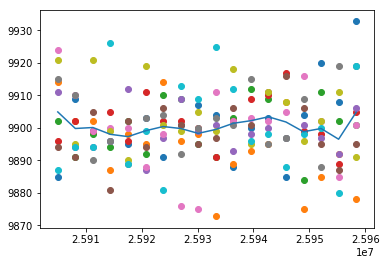

In [72]:
plt.plot(x11[7:25],y2[7:25])
plt.scatter(x11[7:25],y11[7:25])
plt.scatter(x11[7:25],y21[7:25])
plt.scatter(x11[7:25],y31[7:25])
plt.scatter(x11[7:25],y41[7:25])
plt.scatter(x11[7:25],y51[7:25])
plt.scatter(x11[7:25],y61[7:25])
plt.scatter(x11[7:25],y71[7:25])
plt.scatter(x11[7:25],y81[7:25])
plt.scatter(x11[7:25],y91[7:25])
plt.scatter(x11[7:25],y101[7:25])
median1 = np.median(D.y)         
median2 = np.median(y2[7:25])
median12 = median1-median2
print median1, median2, median12 

In [74]:
r = np.sqrt(median12 / median1)
print r

0.10009995005


In [107]:
# try to increase the signal to noise ratio
def bin(arr, k):
    n = (len(arr)/k)/1
    new = []
    for i in range(n-1):
        new.append(np.mean(arr[i*k:(i+1)*k]))
    new.append(np.mean(arr[(n-1)*k:]))
    return new

(array([ 165,  365,  565,  606,  607,  765,  965, 1165, 1365, 1565, 1635,
       1636, 1765, 1965]),)
30300 81750


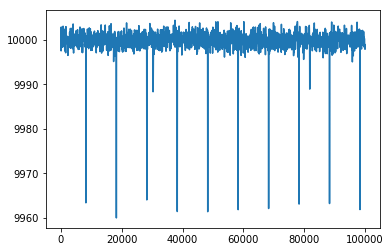

In [130]:
#Another planet
new = bin(D.y, 50)
plt.plot(np.linspace(0,99999,len(new)), new)
a = np.where(np.array(new)<9990)
print a
print 606*100000/len(new), 1635*100000/len(new) # the estimate time for the second planet

In [132]:
p2 = ( 1635*100000/len(new) - 606*100000/len(new) ) * 3140
print p2

161553000


In [145]:
#radius of second
 (10000-np.sum(np.array([new[606], new[607],new[1635],new[1636]]))/2)/(10000-np.mean(np.array([new[165],new[365],new[565],new[760],new[965],new[1165],new[1565], new[1765],new[1965]]))) / ((1636-606)/200.0)

IndentationError: unexpected indent (<ipython-input-145-1a49572b5a18>, line 2)

In [146]:
a = np.array([new[606], new[607],new[1635],new[1636]])
b = (10000 - np.sum(a/2))

c = np.array([new[165],new[365],new[565],new[760],new[965],new[1165],new[1565], new[1765],new[1965]])
d = 10000 - np.mean(c)

e = b/d / ((1636-600)/200.0) # depth
print e

-57.4245927658


In [148]:
r2 = np.sqrt(-e/10000)
print r2

0.0757790160703
